In [22]:
import numpy as np
import matplotlib.pyplot as plt
import galois
from classical_code import *
from utils import get_logicals
from tqdm import tqdm
import pymatching

In [4]:
GF = galois.GF(2)
ccode = read_code("./codes/ccodes/8_6_3_4.code")
H = np.zeros((ccode.m, ccode.n), dtype=int)
for i in range(ccode.m):
    for j in range(ccode.n):
        if (j in ccode.check_nbhd[i]):
            H[i][j] = 1
dim0, dim1 = H.shape
print(H)
print(dim1 - np.linalg.matrix_rank(GF(H)))

[[0 1 1 1 0 0 1 0]
 [0 1 1 0 1 0 0 1]
 [1 0 0 0 1 1 1 0]
 [1 0 1 0 0 1 0 1]
 [1 0 0 1 0 0 1 1]
 [0 1 0 1 1 1 0 0]]
2


(48, 100)
4


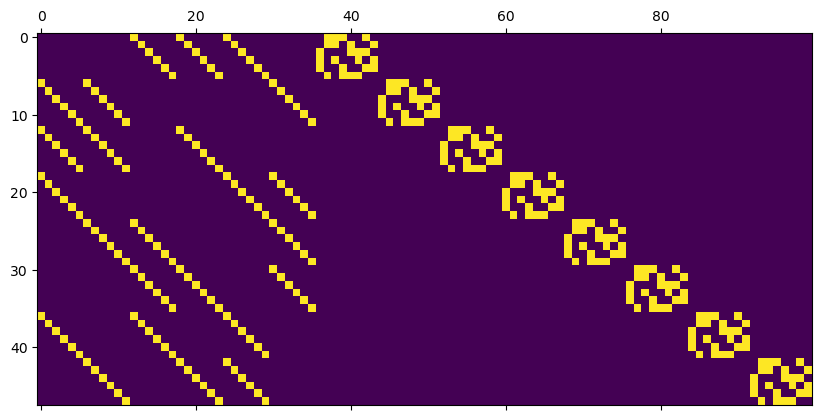

In [5]:
I1 = np.eye(dim1, dtype=int)
I0 = np.eye(dim0, dtype=int)

dE21 = np.kron(H, I0)
dE22 = np.kron(I1, H.T)
dE2 = np.vstack([dE21, dE22])
HGPHz = dE2.T

dE11 = np.kron(I0, H.T)
dE12 = np.kron(H, I1)
dE1 = np.hstack([dE11, dE12])
HGPHx = dE1

print(HGPHz.shape)

HGPzL = get_logicals(HGPHx, HGPHz, False)
HGPxL = get_logicals(HGPHx, HGPHz, True)
print(len(HGPzL))

plt.matshow(HGPHz)

In [6]:
H = np.array([
    [1,1,0],
    [0,1,1]
])
dim0, dim1 = H.shape

1


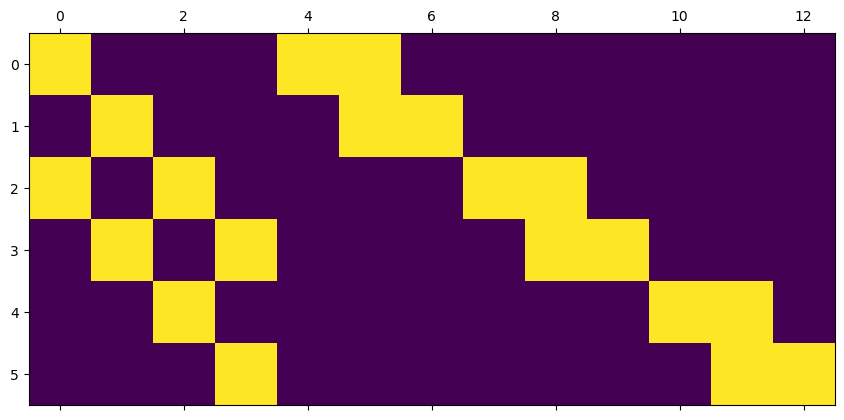

In [12]:
I1 = np.eye(dim1, dtype=int)
I0 = np.eye(dim0, dtype=int)

dE21 = np.kron(H, I0)
dE22 = np.kron(I1, H.T)
dE2 = np.vstack([dE21, dE22])
SurfaceHz = dE2.T

dE11 = np.kron(I0, H.T)
dE12 = np.kron(H, I1)
dE1 = np.hstack([dE11, dE12])
SurfaceHx = dE1

_, n = SurfaceHz.shape
k = 1

SurfacezL = get_logicals(SurfaceHx, SurfaceHz, False)
SurfacexL = get_logicals(SurfaceHx, SurfaceHz, True)
print(len(SurfacezL))

plt.matshow(SurfaceHz)

(600, 1300)


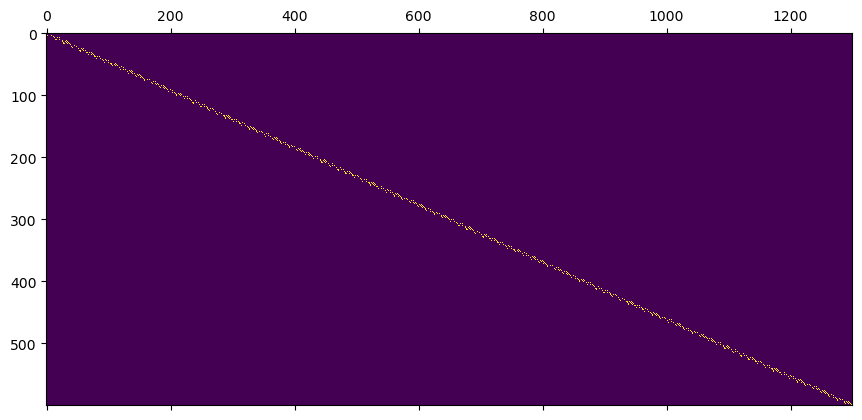

In [31]:
concatenatedStabilizersSurfaceX = np.kron(np.eye(HGPHx.shape[1], dtype=int), SurfaceHx)
concatenatedStabilizersSurfaceZ = np.kron(np.eye(HGPHz.shape[1], dtype=int), SurfaceHz)
print(concatenatedStabilizersSurfaceX.shape)
plt.matshow(concatenatedStabilizersSurfaceX)

In [37]:
concatenatedStabilizersHGPX = np.zeros(shape=(k*HGPHx.shape[0], concatenatedStabilizersSurfaceX.shape[1]), dtype=int)
concatenatedStabilizersHGPZ = np.zeros(shape=(k*HGPHz.shape[0], concatenatedStabilizersSurfaceZ.shape[1]), dtype=int)

for j, xL in enumerate(SurfacexL):
    for i, r in enumerate(HGPHx):
        for x in np.where(r)[0]:
            concatenatedStabilizersHGPX[i+(j*HGPHx.shape[0])][n*x:n*(x+1)] = xL

for j, zL in enumerate(SurfacezL):
    for i, r in enumerate(HGPHz):
        for z in np.where(r)[0]:
            concatenatedStabilizersHGPZ[i+(j*HGPHz.shape[0])][n*z:n*(z+1)] = zL

concatenatedHx = np.vstack([concatenatedStabilizersHGPX, concatenatedStabilizersSurfaceX][::-1])
concatenatedHz = np.vstack([concatenatedStabilizersHGPZ, concatenatedStabilizersSurfaceZ][::-1])

np.savetxt("codes/Hx.txt", concatenatedHx, fmt="%d")
np.savetxt("codes/Hz.txt", concatenatedHz, fmt="%d")

(648, 1300)


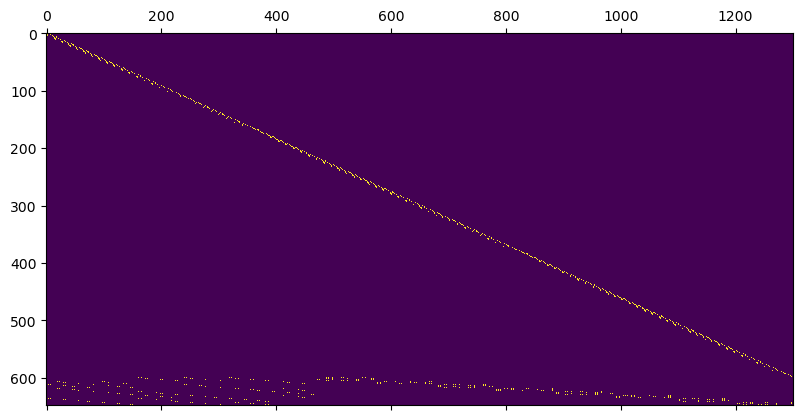

In [33]:
print(concatenatedHx.shape)
plt.matshow(concatenatedHz)

In [34]:
concatenatedxL = np.zeros(shape=(k*HGPxL.shape[0], concatenatedHx.shape[1]), dtype=int)
concatenatedzL = np.zeros(shape=(k*HGPzL.shape[0], concatenatedHz.shape[1]), dtype=int)

for j, xL in enumerate(SurfacexL):
    for i, r in enumerate(HGPxL):
        for x in np.where(r)[0]:
            concatenatedxL[i+(j*HGPxL.shape[0])][n*x:n*(x+1)] = xL

for j, zL in enumerate(SurfacezL):
    for i, r in enumerate(HGPzL):
        for z in np.where(r)[0]:
            concatenatedzL[i+(j*HGPzL.shape[0])][n*z:n*(z+1)] = zL

xL_inds = [np.where(x)[0] for x in concatenatedxL]
zL_inds = [np.where(z)[0] for z in concatenatedzL]

In [36]:
zL_inds

[array([472, 475, 478, 680, 683, 686, 784, 787, 790, 888, 891, 894],
       dtype=int64),
 array([485, 488, 491, 693, 696, 699, 797, 800, 803, 901, 904, 907],
       dtype=int64),
 array([ 576,  579,  582,  992,  995,  998, 1096, 1099, 1102, 1200, 1203,
        1206], dtype=int64),
 array([ 589,  592,  595, 1005, 1008, 1011, 1109, 1112, 1115, 1213, 1216,
        1219], dtype=int64)]

In [20]:
overlapping_x_generators = np.empty(concatenatedStabilizersSurfaceX.shape[0], dtype=object)
for i in range(concatenatedStabilizersSurfaceX.shape[0]):
    tmp = np.array([], dtype=int)
    for j in range(concatenatedStabilizersHGPX.shape[0]):
        if np.any(concatenatedStabilizersSurfaceX[i] & concatenatedStabilizersHGPX[j]): tmp = np.append(tmp, j+concatenatedStabilizersSurfaceX.shape[0])
    overlapping_x_generators[i] = tmp

# overlapping_z_generators = np.empty(concatenatedStabilizersQED.shape[0], dtype=object)
# for i in range(concatenatedStabilizersQED.shape[0]):
#     tmp = np.array([], dtype=int)
#     for j in range(concatenatedStabilizersZQEC.shape[0]):
#         if np.any(concatenatedStabilizersQED[i] & concatenatedStabilizersZQEC[j]): tmp = np.append(tmp, j+concatenatedStabilizersQED.shape[0])
#     overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False):
    overlapping_generators = overlapping_x_generators #if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])
    return list(gens_to_measure)

In [27]:
error_probability = 0.001
weights = np.ones(concatenatedStabilizersSurfaceX.shape[1]) * np.log((1-error_probability)/error_probability)
matching = pymatching.Matching.from_check_matrix(concatenatedStabilizersSurfaceX, weights=weights)
num_shots = 1
num_errors = 0
for i in range(num_shots):
    noise = (np.random.random(concatenatedStabilizersSurfaceX.shape[1]) < error_probability).astype(np.uint8)
    syndrome = concatenatedStabilizersSurfaceX@noise % 2
    predicted_observables = matching.decode(syndrome)
    print(len(predicted_observables))
    # actual_observables = observables@noise % 2
    # num_errors += not np.array_equal(predicted_observables, actual_observables)

print(num_errors)  # prints 6

1300
0


In [30]:
get_overlapping(np.where(syndrome)[0])

[601, 602, 603, 606]